# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Для начала удалим столбцы, которые не влияют на стоимость автомобиля. А именно: дата скачивания анкеты из базы,  месяц регистрации автомобиля, дата создания анкеты, почтовый индекс владельца анкеты (пользователя),дата последней активности пользователя, количество фотографий автомобиля.

In [55]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

При печати df.head() заметили, что существует значение "Power", равное нулю, что должно быть какой-то ошибкой. Проверим, как распределяется мощность автомобилей:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b8442a90>]],
      dtype=object)

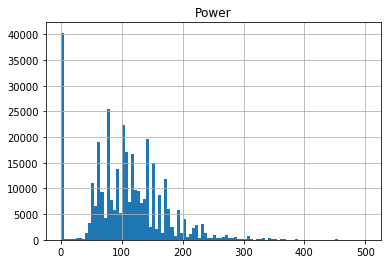

In [56]:
df.hist(column = ['Power'],bins=100, range=(0,500))

Оказалось, что есть много выбросов близких к нулю. Позднее избавимся от них.

### Также проверим распределение цен на автомобили:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7bd1cda50>]],
      dtype=object)

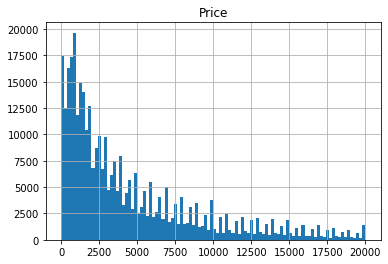

In [57]:
df.hist(column = ['Price'],bins=100)

Цены равные нулю и близкие к нему не вызывают доверия.

### Проверим также распределения года регистрации автомобилей:

Количество автомобилей, зарегистрированных до 1920 или после 2020 года: 274


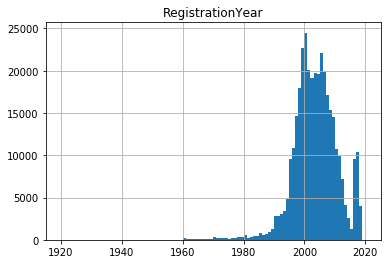

In [71]:
df.hist(column = ['RegistrationYear'],bins=100, range=(1920, 2020))
print('Количество автомобилей, зарегистрированных до 1920 или после 2020 года:',
    df[(df['RegistrationYear']<1920)|(df['RegistrationYear']>2020)]['RegistrationYear'].count())

Существуют выбросы как в меньшую сторону, так и автомобили зарегестрированные в будущем - после 2020 года.

Так как не представляется возможным корректно заполнить пропуски в столбцах 'VehicleType', 'Model', 'NotRepaired' добавим в них новую категорию "other".
В столбцах, распределения которых мы посмотрели выше избавися от недостоверных данных.

In [72]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['Model'] = df['Model'].fillna('other')
df['NotRepaired'] = df['NotRepaired'].fillna('other')

df_new = df[
    (df['Price']>100) &
    (df['RegistrationYear']>1920) & (df['RegistrationYear']<=2020) &
    (df['Power']>0) & (df['Power']<=2000) 
]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305225 entries, 1 to 354368
Data columns (total 10 columns):
Price               305225 non-null int64
VehicleType         305225 non-null object
RegistrationYear    305225 non-null int64
Gearbox             299308 non-null object
Power               305225 non-null int64
Model               305225 non-null object
Kilometer           305225 non-null int64
FuelType            285845 non-null object
Brand               305225 non-null object
NotRepaired         305225 non-null object
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


### После избавимся от оставшихся пропусков методом dropna():

In [73]:
df_new = df_new.dropna()
df_new

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


### Закодируем категориальные данные методом OrdinalEncoder:

In [74]:
encoder = OrdinalEncoder()
encoder.fit(df_new[['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])
df_new[['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoder.transform(
    df_new[['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])

In [75]:
df_new

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,166.0,125000,2.0,1.0,2.0
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
354360,3999,7.0,2005,1.0,3,11.0,150000,2.0,2.0,0.0
354362,3200,4.0,2004,1.0,225,140.0,150000,6.0,30.0,2.0
354366,1199,1.0,2000,0.0,101,106.0,125000,6.0,32.0,0.0
354367,9200,0.0,1996,1.0,102,223.0,150000,2.0,38.0,0.0


### Разделим данные  на обучающую и тестовую выборки:

In [76]:
features = df_new.drop(['Price'], axis = 1)
target = df_new['Price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=123)

### Произведем масштабирование данных:

In [77]:
scaler = StandardScaler()
scaler.fit(features_train)
for i in [features_train, features_valid]:
    i = scaler.transform(i)

# 2. Обучение моделей

In [78]:
model_1 = RandomForestRegressor()
parameters_1 = {'max_depth':range(5,56,10), 'min_samples_split':[2,3,4]}
gread_search_1 = GridSearchCV(
    estimator = model_1, param_grid = parameters_1, scoring= 'neg_mean_squared_error', refit='neg_mean_squared_error', cv=5)

CPU times: user 82 µs, sys: 2 µs, total: 84 µs
Wall time: 93.5 µs


In [79]:
%%time 
GS_model_1 = gread_search_1.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

CPU times: user 7min 6s, sys: 2 s, total: 7min 8s
Wall time: 7min 11s


In [87]:
print('Среднее rmse =', (-GS_model_1.cv_results_['mean_test_score'].mean())**0.5)
print('Лучшие параметры модели: ',GS_model_1.best_params_)

Среднее mse = 1791.0986848038763
Лучшие параметры модели:  {'max_depth': 25, 'min_samples_split': 4}


In [89]:
model_2 = CatBoostRegressor()
parameters_2 = {'iterations':[10, 20], 'depth':[5,10,15]}
gread_search_2 = GridSearchCV(
    estimator = model_2, param_grid = parameters_2, scoring= 'neg_mean_squared_error', refit='neg_mean_squared_error', cv=5)

CPU times: user 113 µs, sys: 2 µs, total: 115 µs
Wall time: 122 µs


In [90]:
%%time
GS_model_2 = gread_search_2.fit(features_train, target_train)

0:	learn: 4542.1721225	total: 71.5ms	remaining: 644ms
1:	learn: 4458.8135686	total: 171ms	remaining: 686ms
2:	learn: 4375.8067894	total: 273ms	remaining: 638ms
3:	learn: 4298.2063894	total: 373ms	remaining: 559ms
4:	learn: 4221.7328423	total: 479ms	remaining: 479ms
5:	learn: 4147.0712456	total: 579ms	remaining: 386ms
6:	learn: 4077.2667764	total: 676ms	remaining: 290ms
7:	learn: 4009.5223431	total: 776ms	remaining: 194ms
8:	learn: 3945.6048700	total: 876ms	remaining: 97.3ms
9:	learn: 3882.0438003	total: 974ms	remaining: 0us
0:	learn: 4536.4018233	total: 38.3ms	remaining: 344ms
1:	learn: 4452.5393334	total: 143ms	remaining: 573ms
2:	learn: 4372.8434963	total: 244ms	remaining: 569ms
3:	learn: 4295.6872195	total: 418ms	remaining: 627ms
4:	learn: 4217.9242651	total: 524ms	remaining: 524ms
5:	learn: 4146.4333916	total: 625ms	remaining: 417ms
6:	learn: 4078.9693945	total: 731ms	remaining: 313ms
7:	learn: 4009.3404026	total: 833ms	remaining: 208ms
8:	learn: 3942.5251645	total: 938ms	remaining

In [91]:
print('Среднее rmse =', (-GS_model_2.cv_results_['mean_test_score'].mean())**0.5)
print('Лучшие параметры модели: ',GS_model_2.best_params_)

Среднее rmse = 3507.674574508618
Лучшие параметры модели:  {'depth': 15, 'iterations': 20}


In [96]:
model_3 = LGBMRegressor()
parameters_3 = {'n_estimators':[10, 30], 'max_depth':[5,10], 'num_leaves':[5,10]}
gread_search_3 = GridSearchCV(
    estimator = model_3, param_grid = parameters_3, scoring= 'neg_mean_squared_error', refit='neg_mean_squared_error', cv=5)

CPU times: user 60 µs, sys: 2 µs, total: 62 µs
Wall time: 67.9 µs


In [97]:
%%time
GS_model_3 = gread_search_3.fit(features_train, target_train)

CPU times: user 14min 15s, sys: 6.05 s, total: 14min 21s
Wall time: 14min 26s


In [98]:
print('Среднее rmse =', (-GS_model_3.cv_results_['mean_test_score'].mean())**0.5)
print('Лучшие параметры модели: ',GS_model_3.best_params_)

Среднее rmse = 2636.7276972303252
Лучшие параметры модели:  {'max_depth': 10, 'n_estimators': 30, 'num_leaves': 10}


### Вывод : c помощью GridSearchCV нашли лучшие параметры для 3-х моделей:
1) RandomForestRegressor
2) CatBoostRegressor
3) LGBMRegressor

# 3. Анализ моделей

### Каждой модели передадим лучшие параметры, найденные выше, вычислим для нее RMSE и время работы.

In [101]:
%%time
model_1 = RandomForestRegressor(max_depth= 25, min_samples_split= 4, random_state=123)
model_1.fit(features_train, target_train)
predictions_1 = model_1.predict(features_valid)
rmse_1 = mean_squared_error(target_valid, predictions_1)**0.5
print('RMSE =',rmse_1)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE = 1615.6484439782728
CPU times: user 10.1 s, sys: 8.47 ms, total: 10.1 s
Wall time: 10.2 s


In [102]:
%%time
model_2 = CatBoostRegressor(depth=15, iterations=20, random_state=123)
model_2.fit(features_train, target_train)
predictions_2 = model_2.predict(features_valid)
rmse_2 = mean_squared_error(target_valid, predictions_2)**0.5
print('RMSE =',rmse_2)

0:	learn: 4523.3562963	total: 1.02s	remaining: 19.5s
1:	learn: 4420.5693291	total: 2.05s	remaining: 18.4s
2:	learn: 4321.5486363	total: 3.25s	remaining: 18.4s
3:	learn: 4226.2625178	total: 4.42s	remaining: 17.7s
4:	learn: 4134.0789775	total: 5.57s	remaining: 16.7s
5:	learn: 4046.1030797	total: 6.64s	remaining: 15.5s
6:	learn: 3961.4338526	total: 7.75s	remaining: 14.4s
7:	learn: 3878.9368821	total: 8.77s	remaining: 13.2s
8:	learn: 3798.4448715	total: 9.91s	remaining: 12.1s
9:	learn: 3722.1723350	total: 11.1s	remaining: 11.1s
10:	learn: 3648.2340251	total: 12.3s	remaining: 10.1s
11:	learn: 3576.4028097	total: 13.4s	remaining: 8.95s
12:	learn: 3506.8892484	total: 14.6s	remaining: 7.88s
13:	learn: 3440.2619768	total: 15.7s	remaining: 6.73s
14:	learn: 3376.4180946	total: 16.8s	remaining: 5.61s
15:	learn: 3312.9354430	total: 17.9s	remaining: 4.48s
16:	learn: 3252.5274782	total: 19s	remaining: 3.35s
17:	learn: 3194.8339626	total: 20.1s	remaining: 2.23s
18:	learn: 3138.7800538	total: 21.2s	rem

In [104]:
%%time
model_3 = LGBMRegressor(max_depth=10, n_estimators=30, num_leaves=10, random_state=123)
model_3.fit(features_train, target_train)
predictions_3 = model_3.predict(features_valid)
rmse_3 = mean_squared_error(target_valid, predictions_3)**0.5
print('RMSE =',rmse_3)

RMSE = 2133.1292978686033
CPU times: user 40.5 s, sys: 341 ms, total: 40.9 s
Wall time: 41.2 s


# Вывод:
Из 3 рассмотренных моделей наименьшее RMSE = 1615  у RandomForestRegressor, также у данной модели наименьшее время работы = 10.2 s